[View in Colaboratory](https://colab.research.google.com/github/dhaalves/modAL/blob/master/AL_selection_strategies.ipynb)

# Dependencies

In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install git+https://github.com/cosmic-cortex/modAL.git
!pip install PyDrive
  
import os

import numpy as np

import pandas as pd

from IPython.core.debugger import set_trace

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras_contrib.applications import ResNet18

from modAL.models import ActiveLearner

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC

from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ei2ohbgj
  Running setup.py bdist_wheel for keras-contrib ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-302qr0kr/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Cloning https://github.com/cosmic-cortex/modAL.git to /tmp/pip-req-build-qewx2en7
  Running setup.py bdist_wheel for modAL ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-9gy_ley5/wheels/96/0e/39/a7f215bb428064bc225557a576a16a6672cd5e1e35bf1b4c75
Successfully built modAL


# Organization/Sampling Code

In [0]:
def unique_without_sorting(array):
    indexes = np.unique(array, return_index=True)[1]
    return [array[idx] for idx in sorted(indexes)]
  
  
def get_knn(x, neighbors=None, n_neighbors=2, return_graph=False):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')
    nbrs.fit(x)
    knn = neighbors if neighbors is not None else x
    if not return_graph:
        knn_dist, knn_idx = nbrs.kneighbors(knn)
        return knn_dist, knn_idx
    else:
        return nbrs.kneighbors_graph(knn, mode='distance')
      

def get_mst_idx(x):
    knn_graph = get_knn(x, n_neighbors=len(x), return_graph=True)
    mst_array = minimum_spanning_tree(knn_graph).toarray()
    nonzero_indices = np.asarray(mst_array.nonzero())
    data_argsort = mst_array[mst_array.nonzero()].argsort()
    idx = nonzero_indices[:, data_argsort].flatten('F')
    return idx[::-1]


def cluster_data(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(x)
    cluster_ids = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    return cluster_ids, cluster_centers
  
  
def get_clusters_dict(cluster_ids):
    clusters_dict = dict()
    y_unique = np.unique(cluster_ids)
    for c in y_unique:
        clusters_dict[c] = np.argwhere(cluster_ids == c).flatten()
        # np.random.shuffle(clusters_dict[c])
    return clusters_dict


def get_mst_cluster_dict(x, cluster_ids):
    cluster_dict = get_clusters_dict(cluster_ids)
    for c in cluster_dict:
        cluster_samples = x[cluster_dict[c]]
        cluster_dict[c] = cluster_dict[c][get_mst_idx(cluster_samples)]
    return cluster_dict
  

def get_rds_cluster_dict(x, cluster_ids, cluster_centers):
    cluster_dict = get_clusters_dict(cluster_ids)
    rds_cluster_dict = dict()
    for i in cluster_dict:
        c_samples = cluster_dict[i]
        if len(c_samples) <= 1:
            continue
        _, knn_idx = get_knn(x[c_samples], neighbors=cluster_centers[i:i + 1],
                             n_neighbors=len(c_samples))
        rds_cluster_dict[i] = c_samples[knn_idx].flatten()
    return rds_cluster_dict


  
def get_mst_cluster_idx(x, cluster_ids, as_edges=True):
    cluster_dict = get_mst_cluster_dict(x, cluster_ids)
    num_samples = sum(map(len, cluster_dict.values()))
    idx = np.empty(0, int)
    while idx.size < num_samples:
        for c in cluster_dict:
            cluster_samples = cluster_dict[c]
            if cluster_samples.size != 0:
                idx = np.append(idx, cluster_dict[c][0])
                cluster_dict[c] = np.delete(cluster_dict[c], 0)
    if not as_edges:
        idx = unique_without_sorting(idx)
    return idx
  


def get_root_idx(x, cluster_centers):
    _, knn_idx = get_knn(x, neighbors=cluster_centers, n_neighbors=1)
    idx = knn_idx.flatten()
    return idx
  
  
def get_boundary_idx(x, cluster_ids, as_edges=True, order=None):
    bedges_dist, bedges_idx = get_bondary_edges(x, cluster_ids)
    if order != None:
        stack = np.column_stack((bedges_dist, bedges_idx))
        if order == 'desc':
            stack = stack[stack[:, 0].argsort()[::-1]]
        elif order == 'asc':
            stack = stack[stack[:, 0].argsort()]
        bedges_idx = stack[:, 1:].astype(int)
    idx = bedges_idx.flatten()
    if not as_edges:
        idx = unique_without_sorting(idx)
    return idx


def get_bondary_edges(x, cluster_ids):
    knn_dist, knn_idx = get_knn(x)
    bedges_idx = np.empty((0, 2), int)
    bedges_dist = np.empty((0, 1), float)
    for i, knn_pair in enumerate(knn_idx):
        if cluster_ids[knn_pair[0]] != cluster_ids[knn_pair[1]] and \
                not np.any(np.all(bedges_idx == np.flip(knn_pair, axis=0), axis=1)):
            bedges_idx = np.vstack((bedges_idx, knn_pair))
            bedges_dist = np.append(bedges_dist, knn_dist[i][1])
    return bedges_dist, bedges_idx

  
def get_root_samples(x, y, cluster_centers):
    idx = get_root_idx(x, cluster_centers)
    return x[idx], y[idx]


def get_boundary_samples(x, y, cluster_ids, as_edges=True, order='desc'):
    idx = get_boundary_idx(x, cluster_ids, as_edges=as_edges, order=order)
    return x[idx], y[idx]


def get_mst_cluster_samples(x, y, cluster_ids, as_edges=False):
    idx = get_mst_cluster_idx(x, cluster_ids, as_edges=as_edges)
    return x[idx], y[idx]

  

def get_samples(x, y, n_clusters=None, type=None):
    n_clusters = len(np.unique(y)) if n_clusters is None else n_clusters
    cluster_ids, cluster_centers = cluster_data(x, n_clusters)
    root_idx = get_root_idx(x, cluster_centers)
    x_initial = x[root_idx]
    y_initial = y[root_idx]
    x_pool = np.delete(x, root_idx, axis=0)
    y_pool = np.delete(y, root_idx, axis=0)
    cluster_ids = np.delete(cluster_ids, root_idx, axis=0)
    idx = np.empty(0, int)
    if type == 'mst-clu-dde':
        idx = get_mst_cluster_idx(x_pool, cluster_ids, as_edges=True)
    elif type == 'mst-clu-ds':
        idx = get_mst_cluster_idx(x_pool, cluster_ids, as_edges=False)
    elif type == 'rds':
        idx = get_rds_cluster_dict(x_pool, cluster_ids, cluster_centers)
    elif type == 'rbe':
        idx = get_boundary_idx(x_pool, cluster_ids, as_edges=True)
    elif type == 'dbe':
        idx = get_boundary_idx(x_pool, cluster_ids, as_edges=True, order='desc')
    elif type == 'mst-be':
        idx = get_boundary_idx(x_pool, cluster_ids, as_edges=False)
        x_pool, y_pool = x_pool[idx], y_pool[idx]
        idx = get_mst_idx(x_pool)
    return idx, x_initial, y_initial, x_pool, y_pool


  

# Query Strategies Code

In [0]:
def rds_selection_strategy(classifier, x, n_instances=1, **kwargs):
    y_root = kwargs.get("y_root")
    dic = kwargs.get("idx")
    query_idx = np.empty(0, int)

    n_samples_left = sum(map(len, dict.values()))
    while(query_idx.size < n_samples_left):
        for l in dic:
            idx = dic[l]
            if idx.size == 0: continue

            pred = classifier.predict(x[idx])
            sel = idx[np.where(pred != y_root[l])]
            if sel.size != 0:
                query_idx = np.append(query_idx, sel[0])
                dic[l] = idx[np.where(idx != sel[0])] ##here
            else:
                query_idx = np.append(query_idx, idx[-1])
                dic[l] = idx[:-1]
            if query_idx.size == n_instances or query_idx.size == n_samples_left:
                return query_idx, dic


    return query_idx, dic

def sequencial_query_strategy(classifier, x, n_instances=1, **kwargs):
    query_idx = np.arange(n_instances)
    return query_idx, x[query_idx]

def sequencial_idx_query_strategy(classifier, x, n_instances=1, **kwargs):
    idx = kwargs.get("idx")
    return idx[:n_instances], idx[n_instances:]

def random_query_strategy(classifier, x, n_instances=1, **kwargs):
    query_idx = np.random.choice(range(len(x)), n_instances)
    return query_idx, x[query_idx]


def disagree_labels_edges_idx_query_strategy(classifier, x, n_instances=1, step=2, **kwargs):

    labeled_idx = kwargs.get("labeled_idx")
    idx = kwargs.get("idx")
    query_idx = np.empty(0, int)
    disagree_edges_idx = np.empty(0, int)
    r = int(len(idx) / step)
    for i in range(r):
        begin = i * step
        end = begin + step
        edge_idx = idx[begin:end]
        pred = classifier.predict(x[edge_idx])
        if np.all(np.in1d(pred[1:], pred[0], invert=True)):
            disagree_edges_idx = np.append(disagree_edges_idx, np.arange(begin, end))
            query_idx = np.append(query_idx, np.array([e for e in edge_idx if e not in labeled_idx and e not in query_idx]).astype(int))
        if query_idx.size >= n_instances:
            return query_idx[:n_instances], np.delete(idx, disagree_edges_idx)

    if query_idx.size < n_instances:
        print('Not enough edges with distinct labels, getting samples with biggest edges')
        edges_left = util.unique_without_sorting(np.delete(idx, disagree_edges_idx)[::-1])
        for e in edges_left:
            if e not in labeled_idx and e not in query_idx:
                query_idx = np.append(query_idx, e)
            if query_idx.size >= n_instances:
                return query_idx[:n_instances], np.delete(idx, disagree_edges_idx)

    return query_idx, np.empty(0, int)


# Load Dataset Code

In [0]:

def download_file_from_drive(filename, unzip=False):
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  if not os.path.exists(filename):
    listed = drive.ListFile({'q': "title contains '" + filename + "'"}).GetList()
    file = listed[0]
    print('title {}, id {}'.format(file['title'], file['id']))
    downloaded = drive.CreateFile({'id': file['id']})
    file = downloaded.GetContentFile(filename)
    if unzip:
      zip_ref = zipfile.ZipFile(filename, "r")
      zip_ref.extractall()
      zip_ref.close()


def load_dataset():
    train_file = 'train_leaves1_inceptionv3.csv'
    test_file = 'test_leaves1_inceptionv3.csv'
    download_file_from_drive(train_file)
    download_file_from_drive(test_file)
    !ls
    dir_path = ''  # os.path.dirname(os.path.realpath(__file__))
    df_train = pd.read_csv(dir_path + train_file)
    df_test = pd.read_csv(dir_path + test_file)

    X_train = df_train.drop('2048', axis=1).as_matrix()
    y_train = df_train['2048'].as_matrix()
    X_test = df_test.drop('2048', axis=1).as_matrix()
    y_test = df_test['2048'].as_matrix()

    pca = PCA(n_components=100, random_state=seed)
    x_pca = pca.fit_transform(np.concatenate((X_train, X_test)))
    X_train = x_pca[:len(X_train)]
    X_test = x_pca[len(X_train):]

    return X_train, y_train, X_test, y_test
  

X_train, y_train, X_test, y_test = load_dataset()

# Keras CNN Models


In [6]:
def create_keras_resnet18():
    model = ResNet18(input_shape=(32, 32, 3), classes=10)
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    return model


def create_keras_cnn():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
    )
    return model

# Plotting


In [0]:
def plot(hist):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['^', 'x', 'o', 'v', '|', '<', '>', '*']
    # list(filter(lambda x: str(x).strip() and str(x) != 'None', Line2D.markers.keys()))
    for i, h in enumerate(hist):
        l = h['label']
        del h['label']
        x = list(h.keys())
        y = list(h.values())
        plt.plot(x, y, 'k', lw=1, mec=colors[i], mfc=colors[i], marker=markers[i], label=l)
    plt.title('Dataset LEAVES-1')
    plt.xlabel('Labeled Samples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Main Learning Cycle

datalab  test_leaves1_inceptionv3.csv  train_leaves1_inceptionv3.csv
0 0.523943661971831 2839 106
1 0.6295774647887324 2736 212
2 0.7338028169014085 2631 318
3 0.7788732394366197 2528 424
4 0.8309859154929577 2423 530
5 0.8690140845070422 2321 636
6 0.8873239436619719 2219 742
7 0.9 2117 848
8 0.9098591549295775 2014 954
9 0.9112676056338028 1912 1060
10 0.9126760563380282 1807 1166
0 0.523943661971831 904 106
1 0.6056338028169014 798 212
2 0.7014084507042253 692 318
3 0.7943661971830986 586 424
Not enough diff labels edges, getting sequencial
4 0.8549295774647887 480 530
Not enough diff labels edges, getting sequencial
5 0.8633802816901408 374 636
Not enough diff labels edges, getting sequencial
6 0.8633802816901408 268 742
Not enough diff labels edges, getting sequencial
7 0.8718309859154929 162 848
Not enough diff labels edges, getting sequencial
8 0.8774647887323944 56 954
Not enough diff labels edges, getting sequencial
9 0.8760563380281691 0 1060
Not enough diff labels edges, get

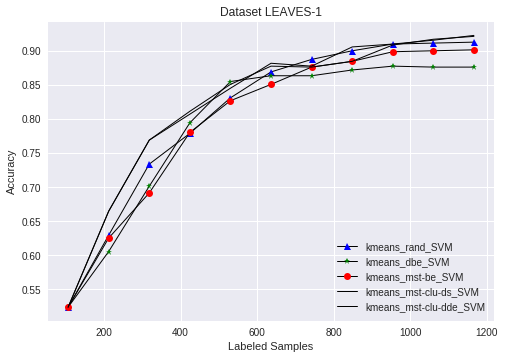

In [30]:
def active_learning(data, max_iterations, n_instances, classifier, query_strategy, **kwargs):
    log = {'label': kwargs.get('label')}
    labeled_idx = np.empty(0, int)
    uncertainty_measures = kwargs.get('uncertainty_measures') is not None

    (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test) = data

    learner = ActiveLearner(
        estimator=classifier,
        X_training=X_initial, y_training=y_initial,
        query_strategy=query_strategy)

    log[n_instances] = learner.score(X_test, y_test)
    print(0, log[n_instances], n_instances)

    for it in range(max_iterations):
        if uncertainty_measures:
            query_idx, query_instance = learner.query(X_pool, n_instances=n_instances)
            learner.teach(X=X_pool[query_idx], y=y_pool[query_idx])
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)
            labeled_instances = (it + 2) * n_instances
        else:
            query_idx, idx = learner.query(X_pool, n_instances=n_instances, idx=idx, labeled_idx=labeled_idx, y_root=y_initial)
            learner.teach(X=X_pool[query_idx], y=y_pool[query_idx])
            labeled_idx = np.append(labeled_idx, query_idx)
            labeled_instances = labeled_idx.size + len(X_initial)

        acc = learner.score(X_test, y_test)
        log[labeled_instances] = acc
        print(it + 1, log[labeled_instances], labeled_instances)
        if not uncertainty_measures and len(idx) == 0: break
    return log





def random_boundary_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters, type='rbe')
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    log = active_learning(data, max_iterations, n_instances, clf, qs.disagree_edges_labels_idx_query_strategy,
                          label='kmeans_rbe_SVM')
    return log


def decreasing_boundary_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters, type='dbe')
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    log = active_learning(data, max_iterations, n_instances, clf, qs.disagree_edges_labels_idx_query_strategy,
                          label='kmeans_dbe_SVM')
    return log


def mst_boundary_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters, type='mst-be')
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    log = active_learning(data, max_iterations, n_instances, clf, qs.disagree_edges_labels_idx_query_strategy,
                             label='Kmeans_mst-be_SVM')
    return log

def mst_cluster_decreasing_sampling(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters,
                                                                 type='mst-clu-ds')
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    log = active_learning(data, max_iterations, n_instances, clf, qs.sequencial_idx_query_strategy,
                           label='kmeans_mst-clu-ds_SVM')
    return log


def mst_cluster_decreasing_disagree_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters,
                                          n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters,
                                                                 type='mst-clu-dde')
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    log = active_learning(data, max_iterations, n_instances, clf, qs.disagree_edges_labels_idx_query_strategy,
                           label='kmeans_mst-clu-dde_SVM')
    return log



def root_distance_sampling(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters,
                                          n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters,
                                                                 type='rds')
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    log = active_learning(data, max_iterations, n_instances, clf, qs.rds_selection_strategy2,
                           label='kmeans_rds_SVM')
    return log

def entropy(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters,
                                          n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters)
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    en = active_learning(data, max_iterations, n_instances, clf, entropy_sampling,
                           label='kmeans_en_SVM', uncertainty_measures=True)
    return en

def margin(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters,
            n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters)
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    mar = active_learning(data, max_iterations, n_instances, clf, margin_sampling,
                           label='kmeans_mar_SVM', uncertainty_measures=True)
    return mar

def uncertainty(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters,
           n_instances):
    idx, X_initial, y_initial, X_pool, y_pool = util.get_samples(X_train, y_train, n_clusters=n_clusters)
    data = (idx, X_initial, y_initial, X_pool, y_pool, X_test, y_test)
    un = active_learning(data, max_iterations, n_instances, clf, uncertainty_sampling,
                          label='kmeans_un_SVM', uncertainty_measures=True)
    return un


def main():
    np.random.seed(seed)
    n_clusters = 106
    n_instances = 106
    max_iterations = 10

    X_train, y_train, X_test, y_test = load_dataset()
    clf = SVC(probability=True, random_state=seed)

    logs = [
        root_distance_sampling(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        # entropy(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        margin(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        # uncertainty(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        random_boundary_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        decreasing_boundary_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        mst_boundary_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        mst_cluster_decreasing_sampling(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
        # mst_cluster_decreasing_disagree_edges(X_train, y_train, X_test, y_test, clf, max_iterations, n_clusters, n_instances),
    ]

    plot(logs)


if __name__ == '__main__':
    global seed
    seed = 1
    main()
